In [17]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 12), dpi=120)
import seaborn as sns
sns.set(style='whitegrid') #set seaborn plotting aesthetics
%matplotlib inline

import pydicom as dcm
from pathlib import Path
import os
from tqdm.notebook import tqdm

In [18]:
train_class = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

train_path = Path('../input/rsna-pneumonia-detection-challenge/stage_2_train_images')
test_path = Path('../input/rsna-pneumonia-detection-challenge/stage_2_test_images')

train_meta = pd.concat([train_labels, 
                        train_class.drop(columns=['patientId'])], axis=1)

box_df = train_meta.groupby('patientId').size().reset_index(name='boxes')

train_ds = pd.merge(train_meta, box_df, on='patientId')

box_df = box_df.groupby('boxes').size().reset_index(name='patients')


# List of information we needs with us
vars = ['PatientAge','PatientSex','ImagePath']


def process_dicom_data(df, path):
    
    # adding new columns to the imported DataFrame with Null values
    for var in vars:
        df[var] = None
        
    images = os.listdir(path)
    
    #looping through each dicom image, extract the information from it, and 
    # add it to the DataFrame
    
    for i, img_name in tqdm(enumerate(images)):
        
        imagePath = os.path.join(path,img_name)
        img_data = dcm.read_file(imagePath)
        
        idx = (df['patientId']==img_data.PatientID)
        df.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        df.loc[idx,'PatientSex'] = img_data.PatientSex
        df.loc[idx, 'ImagePath'] = str.format(imagePath)

process_dicom_data(train_ds,'../input/rsna-pneumonia-detection-challenge/stage_2_train_images')

0it [00:00, ?it/s]

In [19]:
train_ds.to_csv('pneumonia_ds', index=False)

### Pre Processing the image

In [21]:
import cv2

In [22]:
images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []

def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

images, labels = populateImage(train_meta)
print(images.shape , labels.shape)

(30227, 128, 128, 3) (30227,)


Scikitlearn suggests using OneHotEncoder for X matrix i.e. the features you feed in a model, and to use a LabelBinarizer for the y labels.

They are quite similar, except that OneHotEncoder could return a sparse matrix that saves a lot of memory and you won't really need that in y labels.

Even if you have a multi-label multi-class problem, you can use MultiLabelBinarizer for your y labels rather than switching to OneHotEncoder for multi hot encoding.

In [23]:
from sklearn.preprocessing import LabelBinarizer
encode = LabelBinarizer()
y = encode.fit_transform(labels)

## splitting into train ,test and validation data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

# CNN Model without transfer learning

In [36]:
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Activation,Flatten,Dropout,MaxPooling2D,BatchNormalization

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses,optimizers

In [42]:
## We start with 32 filters with 3,3 kernal and no padding , then 64 and 128 wiht drop layers in between 
## And softmax activaation as the last layer

def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))

  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = Adam(lr=0.001)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [43]:
# Model Summary
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)       

In [39]:
## Training for 20 epocs with batch size of 16
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 20, 
                  validation_data = (X_val,y_val),
                  batch_size = 16)

2022-11-25 21:04:00.861558: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1039958016 exceeds 10% of free system memory.
2022-11-25 21:04:02.123058: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1039958016 exceeds 10% of free system memory.
2022-11-25 21:04:02.974914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-25 21:04:05.656697: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1323/1323 [==============================] - ETA: 0s - loss: 1.8599 - accuracy: 0.3876

2022-11-25 21:04:42.167939: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 222904320 exceeds 10% of free system memory.
2022-11-25 21:04:42.869203: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 222904320 exceeds 10% of free system memory.


1323/1323 [==============================] - 42s 21ms/step - loss: 1.8599 - accuracy: 0.3876 - val_loss: 1.0921 - val_accuracy: 0.4033
Epoch 2/20
1323/1323 [==============================] - 27s 21ms/step - loss: 1.0923 - accuracy: 0.3902 - val_loss: 1.0881 - val_accuracy: 0.4033
Epoch 3/20
1323/1323 [==============================] - 26s 20ms/step - loss: 1.0916 - accuracy: 0.3902 - val_loss: 1.0881 - val_accuracy: 0.4033
Epoch 4/20
1323/1323 [==============================] - 27s 20ms/step - loss: 1.0919 - accuracy: 0.3903 - val_loss: 1.0882 - val_accuracy: 0.4033
Epoch 5/20
1323/1323 [==============================] - 27s 20ms/step - loss: 1.0918 - accuracy: 0.3883 - val_loss: 1.0881 - val_accuracy: 0.4033
Epoch 6/20
  28/1323 [..............................] - ETA: 24s - loss: 1.0855 - accuracy: 0.4062

KeyboardInterrupt: 

The Model got stuck at validation accuracy of 40%. Learning rate is too high. Let us also make use of some callbacks.

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]


In [44]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 20, 
                  validation_data = (X_val,y_val),
                  batch_size = 16,
                 callbacks = callbacks)

Epoch 1/20
1323/1323 [==============================] - 28s 20ms/step - loss: 1.1427 - accuracy: 0.4344 - val_loss: 0.9770 - val_accuracy: 0.4639
Epoch 2/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.9557 - accuracy: 0.5086 - val_loss: 0.9596 - val_accuracy: 0.5036
Epoch 3/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.9204 - accuracy: 0.5407 - val_loss: 0.9016 - val_accuracy: 0.5691
Epoch 4/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.8885 - accuracy: 0.5605 - val_loss: 0.9008 - val_accuracy: 0.5720
Epoch 5/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.8677 - accuracy: 0.5757 - val_loss: 0.8906 - val_accuracy: 0.5502
Epoch 6/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.8656 - accuracy: 0.5799 - val_loss: 0.8743 - val_accuracy: 0.5755
Epoch 7/20
1323/1323 [==============================] - 27s 20ms/step - loss: 0.8558 - accuracy: 0.5847 - val_loss: 0.8939 -

Training accuracy is around 60 percent whereas validation accuracy is round 58 percent. We have avoided overfitting, but it seems to be clear that a normal CNN will not help us. 

In [45]:
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

142/142 [==============================] - 2s 12ms/step - loss: 0.8230 - accuracy: 0.6123
Test loss: 0.8230215907096863
Test accuracy: 0.6122629046440125


Test accuracy is also 61 percent is. At least our model is consistent. Hehe. 

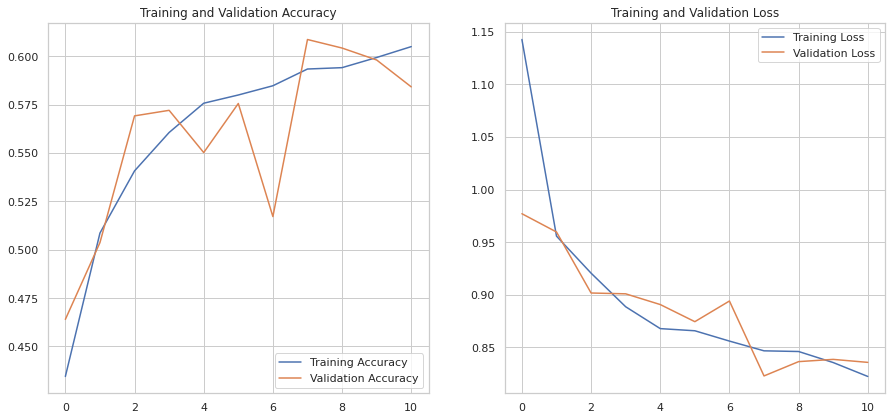

In [48]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(11)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#The training and Validation loss is almost same, but for the training and validation accuracy chart, 
#the validation accuracy falls down in the later epochs, this could be because we have only taken 200 images for processing.

In [49]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [50]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

In [51]:
resultDF

,Method,accuracy,Test Score
0,CNN,0.604925,0.612263


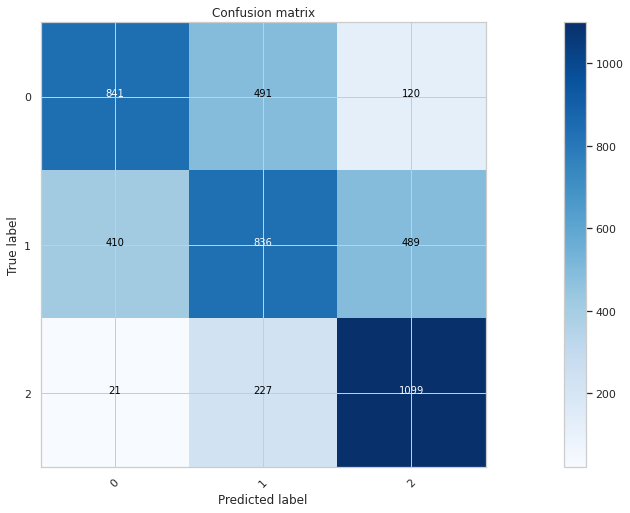

In [52]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

#Class 0 ,1 and 2
#Class 0 is Lung Opacity
#Class 1 is No Lung Opacity/Normal, the model has predicted mostly wrong in this case to the Target 0. Type 2 error
#Class 2 is Normal


In [53]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

for data in reportData:
    if(data == '-1' or data == '1'):
        if(type(reportData[data]) is dict):
            for subData in reportData[data]:
                resultDF[data+"_"+subData] = reportData[data][subData]

resultDF

,Method,accuracy,Test Score,1_precision,1_recall,1_f1-score,1_support
0,CNN,0.604925,0.612263,0.537967,0.481844,0.508361,1735
